Con questo script verrà creato un bot che si collegherà al sito COIN MARKET CAP per estrarre le seguenti informazioni riguardanti le prime 100 criptovalute per capitalizzazione:
<ul>
    <li>1. La criptovaluta con il maggior volume di scambi </li>
    <li>2. Le 10 migliori e le 10 peggiori cripto per variazione percentuale nelle ultime 24 ore</li>
    <li>3. Quantità di denaro necessaria ad acquistare un'unità delle prime 20 cripto più capitalizzate. </li>
    <li>4. Quantità di denaro necessaria ad acquistare un'unità delle cripto il cui volume nelle ultime 24 ore sia stato superiore a 76.000.000$ </li>
    <li>5. Guadagno (o perdita) percentuale che avremmo realizzato se avessimo comprato un'unità di ciascuna criptovaluta il giorno prima. </li>
    
   


In [ ]:
import requests
import schedule
import time
from datetime import datetime
import json

# definiamo la classe del bot

class Bot:
    def __init__(self):
        self.url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest" # sito a cui si aggancerà
        self.params = {
            "start": "1",
            "limit": "100",
            "convert": "USD"
            } # impostiamo limite di visualizzazione e valuta
        self.headers = {
            "Accepts": "application/json",
            "X-CMC_PRO_API_KEY": "*****" # al posto degli asterisci vanno inserite le proprie credenziali
            }
    # funzione per ricavare i dati
    def fetchCurrenciesData(self):
        r = requests.get(url = self.url, headers = self.headers, params = self.params).json()
        return r["data"]


impactBot = Bot()
currencies = impactBot.fetchCurrenciesData()


dictJson = {} # dizionario che verrà converito nel file Json

''' 1) TROVIAMO LA CRIPTOVALUTA CON VOLUME MAGGIORE'''
def find_top_volume():
    
    topVolume = None
    #semplice ciclo che aggiorna la variabile man mano che trova un valore più alto
    for currency in currencies:
        if not topVolume or topVolume["quote"]["USD"]["volume_24h"] < currency["quote"]["USD"]["volume_24h"]:
            topVolume = currency
    #aggiungiamo il valore trovato al dizionario che verrà convertito in Json
    dictJson["Highest_volume_crypto"] =  {topVolume["symbol"]: '{0:.2f}'.format(topVolume["quote"]["USD"]["volume_24h"])}

    
'''2) TROVIAMO LE MIGLIORI E PEGGIORI 10 CRIPTOVALUTE (PER INCREMENTO PERCENTUALE DELLE ULTIME 24 ORE)'''
def get_top10_worst10():
    topTen = {}
    worstTen = {}
    allCurrencies = {}
    # creo un dizionario che contenga come coppie di valori il simbolo della cripto e la variazione% delle ultime 24h
    for currency in currencies:
        allCurrencies[currency["symbol"]] = currency["quote"]["USD"]["percent_change_24h"]
    # ordino il dizionario per variazione crescente
    allCurrencies = {k: v for k, v in sorted(allCurrencies.items(), key = lambda item: item[1])}

    # aggiungo alla lista "worst_ten" le prime 10 cripto della lista che, essendo la lista
    # in ordine crescente, saranno quelle con la peggior variazione
    c = 0
    for symbol, variation in allCurrencies.items():
        worstTen[symbol] = '{0:.2f}'.format(variation)
        c += 1
        if c == 10:
            break
    dictJson["Top10_worst_performances_24hours"]= worstTen

    # ripeto il ciclo precedente, ma metto come condizione (tramite if) che aggiunge solo gli ultimi 10 valori
    c = 0
    for symbol, variation in allCurrencies.items():
        if (len(allCurrencies) - c) > 10:
            pass
        else:
            topTen[symbol] = '{0:.2f}'.format(variation) #aggiungo i valori sono se sono gli ultimi 10
        c += 1
    
    # questa volta ordino in modo decrescente, per avere l'aumento maggiore al primo posto
    topTen = {k: v for k, v in reversed(topTen.items())}
    dictJson["Top10_best_performances_24hours"] = topTen
    
    
'''3)TROVIAMO LA QUANTITA' DI DENARO NECESSARIA AD ACQUISTARE UNA
UNITA' DELLE PRIME 20 CRIPTOVALUTE PIU' CAPITALIZZATE'''
def get_top20_MarketCap():
    # poichè sono già ordinate per capitalizzazione su Coinmarket, basterà eseguire un ciclo sulle prime 20 cripto e sommarne i prezzi
    c = 0
    budget = 0
    for currency in currencies:
        budget += currency["quote"]["USD"]["price"]
        c += 1
        if c == 20:
            break
    dictJson["Budget_to_buy_top20_marketCap"] = '{0:.2f}'.format(budget)

    
'''4)TROVIAMO QUANTO DENARO E' NECESSARIO PER COMPRARE TUTTE LE CRIPTOVALUTE
IL CUI VOLUME DELLE ULTIME 24 ORE SIA SUPERIORE A  76.000.000$'''
def get_volume_over76M():
    
    # creiamo un cliclo che sommi il prezzo di tutte le cripto che hanno avuto il volume richiesto
    budget = 0
    for currency in currencies:
        if currency["quote"]["USD"]["volume_24h"] > 76000000:
            budget += currency["quote"]["USD"]["price"]

    dictJson["Budget_to_buy_volume_crypto_over76M"] = '{0:.2f}'.format(budget)


''' 5) TROVIAMO IL GUADAGNO (O PERDITA) PERCENTUALE CHE AVREMMO REALIZZATO SE AVESSIMO COMPRATO UNA 
UNITA' DI CIASCUNA CRIPTOVALUTA IL GIORNO PRIMA'''
def get_daily_variation():
    todayValue = 0
    yesterdayValue = 0
    variation = 0
    c = 0

    for currency in currencies:
        #formula per trovaro il valore di ieri: prezzo di oggi / (1 + variazione percentuale)
        yesterdayValue += (currency["quote"]["USD"]["price"] / (1 + (currency["quote"]["USD"]["percent_change_24h"]/100))) #faccio il totale dei prezzi di ieri
        todayValue += currency["quote"]["USD"]["price"] #totale dei prezzi di oggi
        c += 1
        if c == 20:
            break

    #formula per la variazione percentuale: (tot di oggi - tot di ieri) / tot di ieri (moltiplicato per 100 per ottenere la percentuale)
    variation = (todayValue - yesterdayValue) / yesterdayValue  * 100

    if variation > 0:
        dictJson["Profit%"] = '{0:.2f}'.format(variation)
    elif variation < 0:
        dictJson["Lost%"] = '{0:.2f}'.format(variation)
    else:
        dictJson["NoVariation"] = '{0:.2f}'.format(variation)

'''CREO LA FUNZIONE CON CUI VERRA' SALVATO IL REPORT'''
def save_report():
    # otteniamo la data nel formato desiderato
    today = datetime.now()
    today = today.strftime("%d.%m.%Y")

    #salvimo il report ottenuto in Json
    path = "C:/Users/matti/OneDrive/Desktop/S2I/Report_crypto/" # scegliamo la cartella in cui salvare il report
    dest = path + "Report_" + today + ".json"
    with open(dest, "w") as outfile:
        json.dump(dictJson, outfile)

    # come ultima cosa svuotiamoo il dizionario per prepararlo al prossimo report
    # dictJson = {}

'''INFINE USIAMO IL MODULO SCHEDUL PER ESEGUIRE LE NOSTRE FUNZIONI TUTTI I GIORNI AD UNA DETERMINATA ORA (IPOTIZZIAMO 22.30)'''


schedule.every().day.at("22:30").do(find_top_volume)
schedule.every().day.at("22:30").do(get_top10_worst10)
schedule.every().day.at("22:30").do(get_top20_MarketCap)
schedule.every().day.at("22:30").do(get_volume_over76M)
schedule.every().day.at("22:30").do(get_daily_variation)
schedule.every().day.at("22:30").do(save_report)

while True:
    schedule.run_pending()
    time.sleep(1)

Se ora caricassimo il file json generato otteremmo la seguente visualizzazione:

In [37]:
rep = open(dest)
data = json.load(rep)
for d in data.keys():
    print(f"{d}:\n{data[d]}\n")
    
rep.close()

Highest_volume_crypto:
{'USDT': '45495397520.88'}

Top10_worst_performances_24hours:
{'IOTX': '-5.79', 'AMP': '-4.49', 'THETA': '-4.18', 'XTZ': '-3.15', 'ATOM': '-2.45', 'CRV': '-1.78', 'WAVES': '-1.61', 'ADA': '-1.45', 'AAVE': '-1.30', 'SAND': '-1.15'}

Top10_best_performances_24hours:
{'XRP': '7.58', 'STX': '5.00', 'KDA': '4.26', 'LUNA': '3.95', 'SHIB': '3.43', 'XMR': '3.14', 'BORA': '2.96', 'CRO': '2.94', 'BCH': '2.90', 'ETC': '2.84'}

Budget_to_buy_top20_marketCap:
88576.47

Budget_to_buy_volume_crypto_over76M:
90108.12

Profit%:
0.24



Questo invece è lo screen della visualizzazione che otteniamo aprendo direttamente il file:

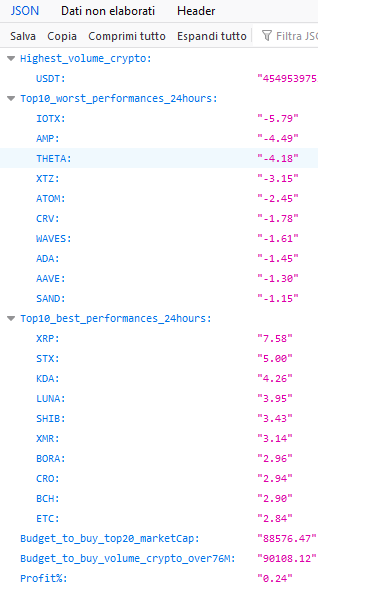

In [28]:
from IPython.display import Image
Image(filename="screen_report.png") 